In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.get_device_name(0))
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")


NVIDIA GeForce RTX 2080 SUPER


# Load FashionMNIST Data

In [139]:
fashion_train = datasets.FashionMNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

fashion_test = datasets.FashionMNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [140]:
batch_size = 128
train_loader  = torch.utils.data.DataLoader(dataset=fashion_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_batch_size = 32
test_loader = torch.utils.data.DataLoader(dataset=fashion_test,
                                         batch_size=test_batch_size,
                                         shuffle=False)

In [142]:
train_loader.dataset[0][0].shape

torch.Size([1, 28, 28])

# Train Model

In [143]:
from models import Net, get_resnet18_MNIST

model = get_resnet18_MNIST().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [144]:
num_epochs = 5

for epoch in range(num_epochs):

    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        # X = atk(batch_images, batch_labels).cuda()

        X = batch_images.cuda()
        Y = batch_labels.cuda()

        outputs = model(X)
        # _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [%d/%d], Loss: %.4f'
        %(epoch+1, num_epochs, loss.item()))

Epoch [1/5], Loss: 0.2779
Epoch [2/5], Loss: 0.2354
Epoch [3/5], Loss: 0.1958
Epoch [4/5], Loss: 0.1652
Epoch [5/5], Loss: 0.1508


## Standard Testing

In [145]:
correct = 0
total = 0

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)

        outputs = model(data)

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy {100 * correct // total} %')

Accuracy 87 %


## Adversarial Attack

In [146]:
from attacks import test_robustness

# Run Attack

In [169]:
# eps = 0 means no attack
epsilons = [0, .05, .1, .15, .2, .25, .3]

# accuracies of each eps test
accuracies = []

# resulting adversarial examples
examples = []

# resulting perturbations
perturbations = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex, adv_per = test_robustness(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    perturbations.append(adv_per)

Epsilon: 0	Test Accuracy = 8774 / 10000 = 0.8774
Epsilon: 0.05	Test Accuracy = 4382 / 10000 = 0.4382
Epsilon: 0.1	Test Accuracy = 2781 / 10000 = 0.2781
Epsilon: 0.15	Test Accuracy = 2115 / 10000 = 0.2115
Epsilon: 0.2	Test Accuracy = 1823 / 10000 = 0.1823
Epsilon: 0.25	Test Accuracy = 1637 / 10000 = 0.1637


## Perturbations

In [204]:
accuracies

[0.8774, 0.4382, 0.2781, 0.2115, 0.1823, 0.1637]

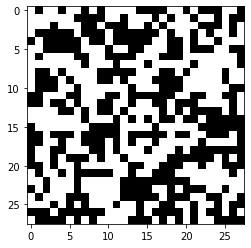

In [184]:
for p in perturbations:
    if (len(p) > 0):
        p = p[0][0].squeeze().detach().cpu().numpy()
        plt.imshow(p, cmap="gray")


Text(0.5, 1.0, 'Original Image')

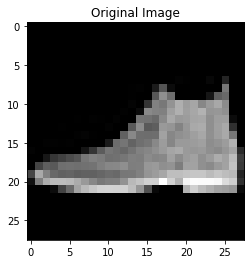

In [185]:
original_img = examples[1][0][3][0][0].squeeze().detach().cpu().numpy()
plt.imshow(original_img, cmap="gray")
plt.title("Original Image")

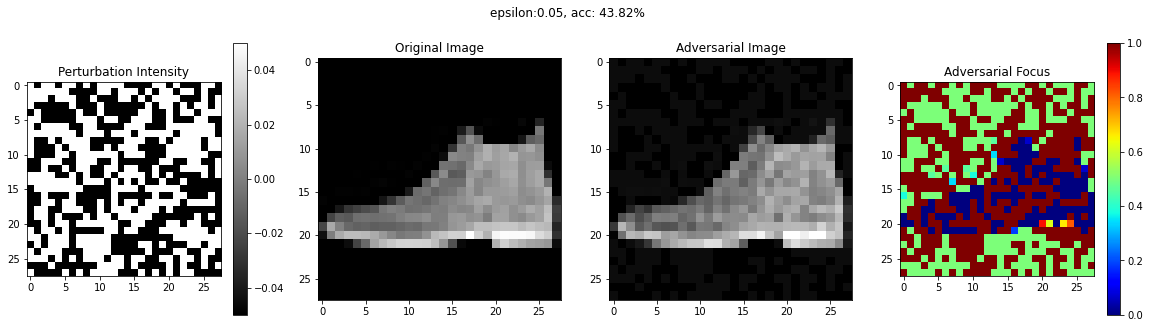

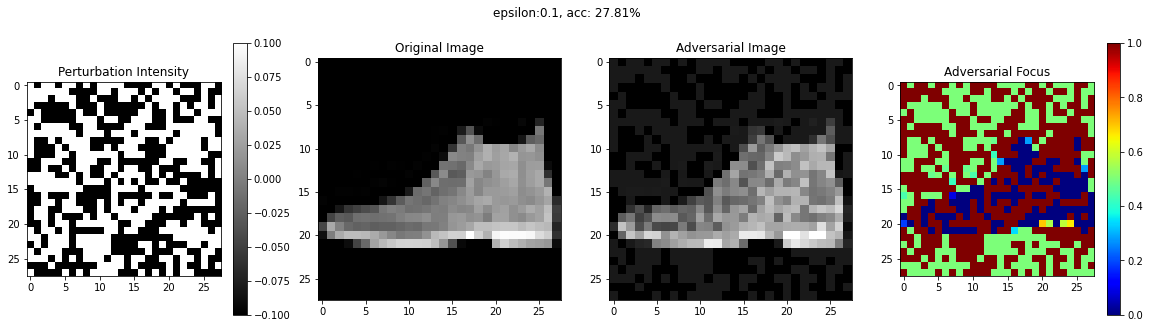

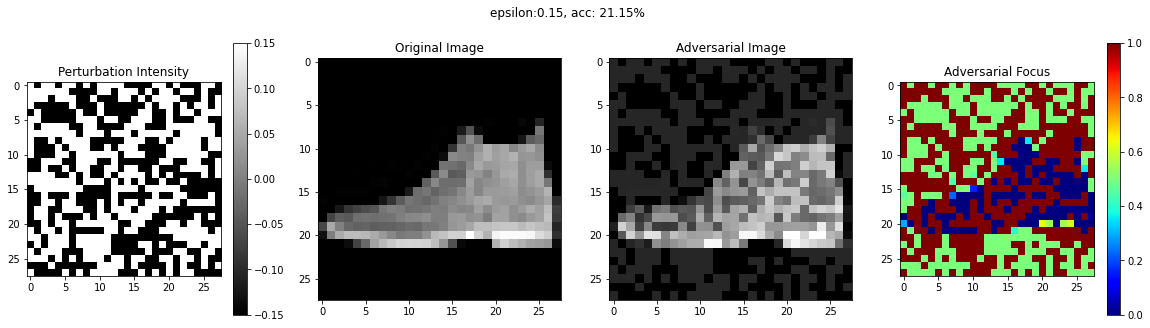

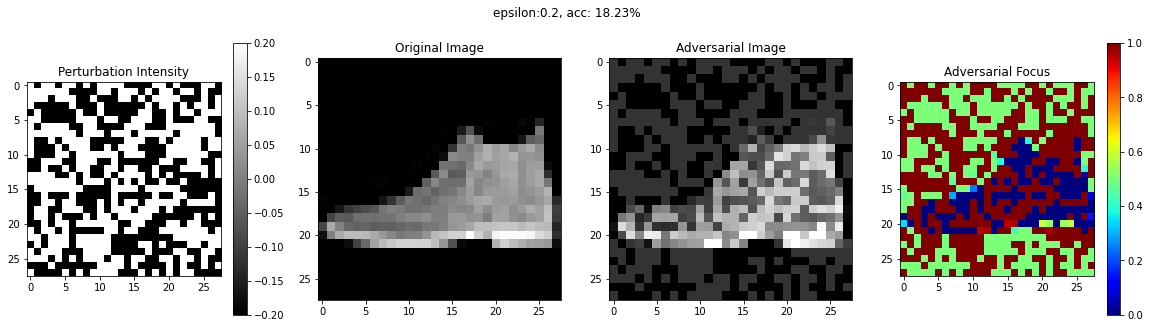

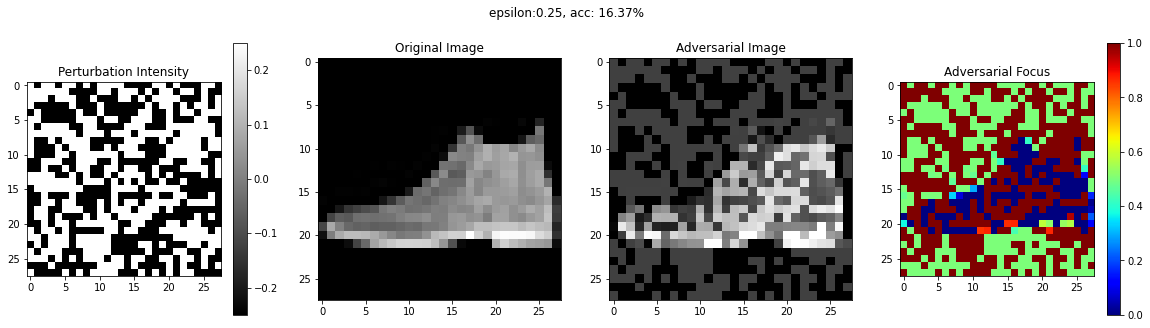

In [207]:
for e, e_value in enumerate(epsilons):
    if e == 0: continue
    
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"epsilon:{e_value}, acc: {np.round(accuracies[e] * 100, 4)}%")
    i = 1
    plt.subplot(1,4,1)
    p = perturbations[e][i][0][0].squeeze().detach().cpu().numpy()
    plt.imshow(p, cmap="gray")
    plt.title(f"Perturbation Intensity")
    plt.colorbar()

    plt.subplot(1,4,2)
    original_img = examples[e][i][3][0][0].squeeze().detach().cpu().numpy()
    plt.imshow(original_img, cmap="gray")
    plt.title("Original Image")


    plt.subplot(1,4,3)
    adv_img = examples[e][i][2][0]
    plt.imshow(adv_img, cmap="gray")
    plt.title("Adversarial Image")

    plt.subplot(1,4, 4)
    diff = adv_img - original_img
    # MinMax Scaling [0,1]
    diff = (diff - diff.min()) / (diff.max() - diff.min())
    plt.imshow(diff, cmap='jet')
    plt.colorbar()
    plt.title("Adversarial Focus")
    plt.show();


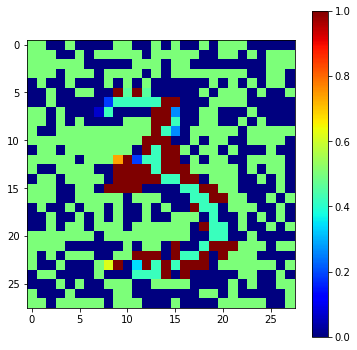

In [137]:
diff = original_img - adv_img
diff = (diff - diff.min()) / (diff.max() - diff.min())
plt.figure(figsize=(6,6))
plt.imshow(diff, cmap='jet')
plt.colorbar()
plt.show()

## TODO: Transfer Robustness via Adversarial Perturbations

In [218]:
accuracies_demo = [0.90, 0.60, 0.40, 0.31, 0.25, 0.22]

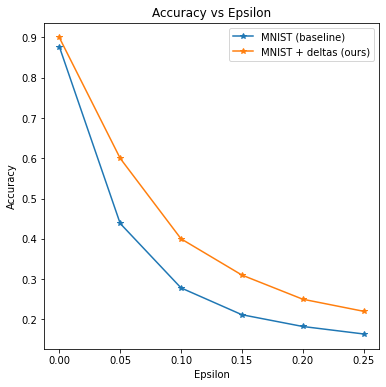

In [220]:
plt.figure(figsize=(6,6))
plt.plot(epsilons, accuracies, "*-", label = "MNIST (baseline)")
plt.plot(epsilons, accuracies_demo, "*-", label = "MNIST + deltas (ours)")
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# *TODO*: GradCam

In [102]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [103]:
input_tensor = test_loader.dataset[0][0]
# input_tensor = .
input_tensor = input_tensor.reshape(1, 1, 28, 28)
input_tensor.shape

torch.Size([1, 1, 28, 28])

In [111]:
target_layers = [model.layer4[-1]] # for ResNet18 and ResNet50

cam = GradCAM(model=model, target_layers=target_layers, use_cuda = True)

targets = [ClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

In [123]:
# visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

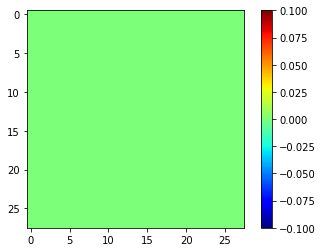

In [126]:
plt.imshow(grayscale_cam, cmap='jet')
plt.colorbar()
plt.show()